# Чтение данных

Код подготовлен студентом 201 группы ВМК МГУ Боровко Никитой как сопровождение к реферату.

In [ ]:
!pip install scikit-surprise
!pip install implicit
!pip install git+https://github.com/coreylynch/pyFM

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from surprise import prediction_algorithms
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import Reader
from surprise import accuracy
import implicit
import torch
import matplotlib.pyplot as plt
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv('./ratings.csv', names=['user', 'item', 'score', 'timestamp'])
train = train.drop('timestamp', 1)
train = train.drop(0)
train = train.reset_index()
train = train.drop('index', 1)
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,user,item,score
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
train['user'] = pd.to_numeric(train['user'])
train['item'] = pd.to_numeric(train['item'])

In [ ]:
matrix_train = train.pivot_table(columns='item', index='user', values='score').fillna(0).to_numpy()
print(matrix_train.shape)
matrix_train

(610, 9724)


array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
def train_split(user_item, test_size=0.3):
    X_train = np.zeros(user_item.shape)
    X_test = np.zeros(user_item.shape)
    np.random.seed(1367)
    has_score = np.argwhere(user_item > 0)
    np.random.shuffle(has_score)
    split = int(len(has_score) * test_size)
    test = has_score[:split]
    train = has_score[split:]
    for i, idx in enumerate(train):
        X_train[idx[0], idx[1]] = user_item[idx[0], idx[1]]
    for i, idx in enumerate(test):
        X_test[idx[0], idx[1]] = user_item[idx[0], idx[1]]
    return X_train, X_test

# Alternating Least Squares

In [ ]:
class MyALS:
    
    def __init__(self, iterations=15, latent_features=5, alpha=40, lambda_reg=10, neg_sampling=0.85, conf_w=10, implicit=0):
        self.iterations = iterations
        self.latent_features = latent_features
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.neg_sampling = neg_sampling
        self.conf_w = conf_w
        self.implicit = implicit
        np.random.seed(1367)
        
    def fit(self, train, test=None):
        user_size, item_size = train.shape
        matrix_full = np.zeros_like(train)
        mean_score = train[(train > 0)].mean()
        for u in range(user_size):
            for i in range(item_size):
                if train[u][i]:
                    matrix_full[u][i] = train[u][i]

        C = np.ones(train.shape) + self.alpha * np.log(np.ones(train.shape) + train * self.conf_w)   
        C_I = C - 1
        lambda_I = self.lambda_reg * sparse.eye(self.latent_features + 1)
 
        # user u x f
        X = np.hstack([np.ones((user_size, 1)), np.random.normal(size=(user_size, self.latent_features))])
        # item i x f
        Y = np.hstack([np.ones((item_size, 1)), np.random.normal(size=(item_size, self.latent_features))])
        # biased als
        X_bias = np.array([0] * user_size)
        Y_bias = np.array([0] * item_size)
        
        n_user = (train > 0).sum(1)
        n_item = (train > 0).sum(0)
        
        history = [[], [], []]
        MIN_LOSS = 9999999
        MIN_ITER = 9999999
        for iteration in range(self.iterations):            
            # User step
            yTy = np.dot(Y.T, Y)
            Cu = C * (matrix_full - Y_bias)
            for u in range(user_size):
                # X = ((Y.T*Y + Y.T*(C - I) * Y) + lambda*I)^-1 * (Y.T * Cu)
                inv = np.linalg.inv(yTy + np.dot(Y.T * C_I[u], Y) + lambda_I * n_user[u])
                X[u] = np.dot(np.dot(inv, Y.T), Cu[u].reshape(-1, 1)).ravel()
            X_bias = X[:, 0].copy().reshape(-1, 1)
            X[:, 0] = 1
                
            # Item step
            xTx = np.dot(X.T, X)
            Ci = C * (matrix_full - X_bias)
            for i in range(item_size):
                # Y = ((X.T*X + X.T*(C - I) * X) + lambda*I)^-1 * (X.T * Ci)
                inv = np.linalg.inv(xTx + np.dot(X.T * C_I[:, i], X) + lambda_I * n_item[i])
                Y[i] = np.dot(np.dot(inv, X.T), Ci[:, i].reshape(-1, 1)).ravel()
            Y_bias = Y[:, 0].copy().ravel()
            Y[:, 0] = 1
            
            result = np.dot(X[:, 1:], Y[:, 1:].T) + X_bias + Y_bias
            result[result > 5] = 5
            result[result < 0.5] = 0.5
            
            if test is not None:
                rmse = np.sqrt(((result * (test > 0) - test) ** 2).sum() / (test > 0).sum())
                rmset = np.sqrt(((result * (train > 0) - train) ** 2).sum() / (train > 0).sum())
                history[0].append(iteration)
                history[1].append(rmse)
                history[2].append(rmset)
                if rmse < MIN_LOSS:
                    MIN_LOSS = rmse
                    MIN_ITER = iteration
                    #print("CUR MIN:", rmse, iteration, self.latent_features, self.alpha, self.lambda_reg, self.neg_sampling, self.conf_w)
                print("Test score:", str(iteration) + " | " + str(rmse) + " | " + str(rmset))
            else:
                rmse = np.sqrt(((result * (train > 0) - train) ** 2).sum() / (train > 0).sum())
                #print("Train score:", str(iteration) + " | " + str(rmse))
                
#        return MIN_LOSS, MIN_ITER, self.latent_features, self.alpha, self.lambda_reg, self.neg_sampling, self.conf_w
        return result, history

In [ ]:
X_train, X_test = train_split(matrix_train, test_size = 0.33)

my_model_20 = MyALS(latent_features=20)
history_20 = my_model_20.fit(X_train, X_test)[1]
my_model_15 = MyALS(latent_features=15)
history_15 = my_model_15.fit(X_train, X_test)[1]
my_model_10 = MyALS(latent_features=10)
history_10 = my_model_10.fit(X_train, X_test)[1]
my_model_5 = MyALS(latent_features=5)
history_5 = my_model_5.fit(X_train, X_test)[1]

Test score: 0 | 1.379348013428643 | 1.0496438384340387
Test score: 1 | 1.4572639250914574 | 0.694260397219265
Test score: 2 | 1.483903909723292 | 0.6233782245459155
Test score: 3 | 1.4985990742047552 | 0.5904838777316735
Test score: 4 | 1.507462487741026 | 0.5725760301882492
Test score: 5 | 1.5128122283363672 | 0.5619543947338492
Test score: 6 | 1.5159317126604661 | 0.5552216553465802
Test score: 7 | 1.517717202490466 | 0.5507204069335164
Test score: 8 | 1.5188006341609537 | 0.5475653492732666
Test score: 9 | 1.5193985544126924 | 0.5452603482566115
Test score: 10 | 1.519700388385326 | 0.5435194927384487
Test score: 11 | 1.519843528405876 | 0.5421705417837539
Test score: 12 | 1.519851534707597 | 0.5411031417325033
Test score: 13 | 1.5197823375095578 | 0.5402456469499165
Test score: 14 | 1.5197080295668324 | 0.5395452719668026
Test score: 0 | 1.3683367882187698 | 1.0860726907372003
Test score: 1 | 1.434177871106279 | 0.7526180939712283
Test score: 2 | 1.4558085055368066 | 0.6835002981817

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [1.3579657808181378, 1.4059125666943522, 1.397555677426628, 1.3810320155247031, 1.370913949556398, 1.366454700728951, 1.3638052748535594, 1.3612040222740955, 1.3586109209520068, 1.3560538834200786, 1.3537519581065012, 1.3517935925825229, 1.350274666165696, 1.3491135026802206, 1.3481772178588687], [1.1672410870814571, 0.9496258266109586, 0.8947476406061907, 0.8713052230332792, 0.8593223141702356, 0.8530262476697077, 0.8494670843706753, 0.8472592654108428, 0.8457420247976578, 0.8445926852024747, 0.8436577670000153, 0.8428519456619059, 0.8421328963575818, 0.841502875385091, 0.8409846617956173]]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [1.3667389381139718, 1.4311997181799476, 1.4328121876286597, 1.427415846048096, 1.4237364451078849, 1.4214650452627406, 1.4196467811481863, 1.418178643641732, 1.417063559226066, 1.4162654038996358, 1.4157368985799363, 1.4153984630352818, 1.41520029065418, 1.415027440329254, 1.414856216878593], 

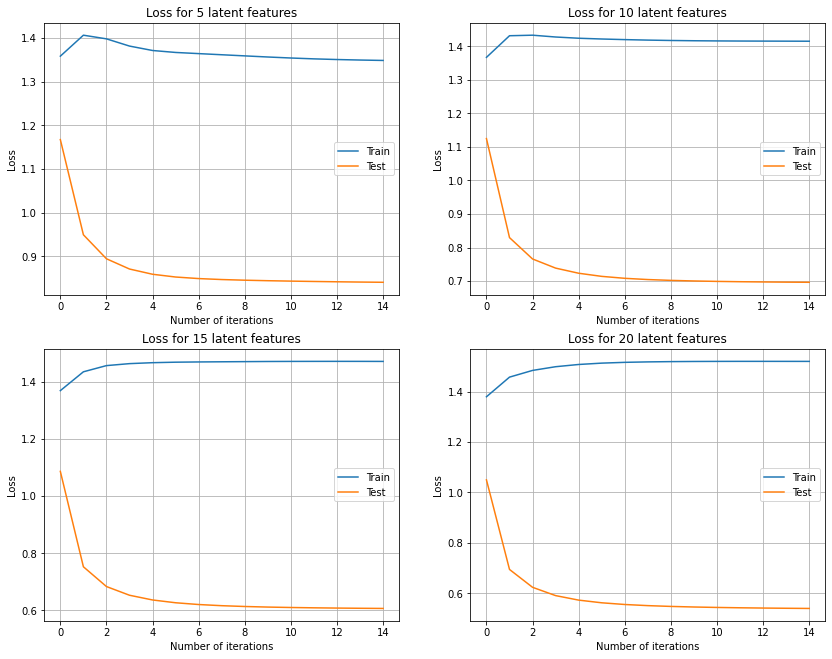

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
histories = [history_5, history_10, history_15, history_20]

for i in range(0, 4):
    ax = axs[(i // 2, i % 2)]
    print(histories[i])
    ax.plot(histories[i][0], histories[i][1], label='Train')
    ax.plot(histories[i][0], histories[i][2], label='Test')
    ax.set_title(f'Loss for {(i+1) * 5} latent features')
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid()

plt.show()

# Singular Value Decomposition

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))
data_s = Dataset.load_from_df(train, reader)

In [ ]:
results_svd = []

trainset, testset = train_test_split(data_s, test_size=.33)

for i in range(5, 51, 5):
    algo_svd = prediction_algorithms.SVD(n_factors=i, n_epochs=10 + i // 5 * 2)
    cross_validate(algo_svd, data_s, measures=['RMSE'], cv=5, verbose=True)
    #algo_svd.fit(trainset)
    results_svd.append(accuracy.rmse(algo_svd.test(testset)))


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8787  0.8768  0.8697  0.8745  0.8743  0.8748  0.0030  
Fit time          0.99    1.02    1.04    1.02    1.02    1.02    0.01    
Test time         0.17    0.47    0.15    0.31    0.18    0.25    0.12    
RMSE: 0.8459
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8787  0.8698  0.8783  0.8662  0.8733  0.8733  0.0048  
Fit time          1.30    1.31    1.34    1.34    1.32    1.32    0.01    
Test time         0.13    0.18    0.33    0.14    0.15    0.19    0.07    
RMSE: 0.8363
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8641  0.8739  0.8829  0.8702  0.8671  0.8716  0.0065  
Fit time          1.70    1.69    1.74    1.73    1.68    1.71    0.02    
Te

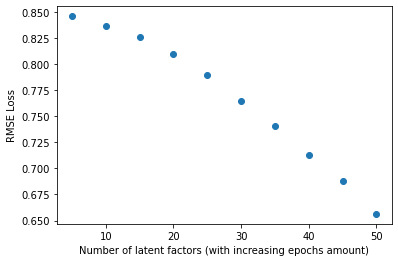

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.arange(5, 51, 5), results_svd, label='RMSE loss')
ax.set_xlabel('Number of latent factors (with increasing epochs amount)')
ax.set_ylabel('RMSE Loss')
fig.show()

In [ ]:
store = train.to_numpy()
np.random.shuffle(store)
src_train = store[:store.shape[0] // 2]
src_test = store[store.shape[0] // 2:]

def load_data(src):
    data = []
    y = []
    for i in src:
        data.append({ "user_id": str(i[0]), "movie_id": str(i[1])})
        y.append(float(i[2]))
    return data, y

train_data, train_y = load_data(src_train)
test_data, test_y = load_data(src_test)
v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)

In [ ]:
fm_5 = pylibfm.FM(num_factors=5, num_iter=50, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
fm_10 = pylibfm.FM(num_factors=10, num_iter=50, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
fm_15 = pylibfm.FM(num_factors=15, num_iter=50, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
fm_20 = pylibfm.FM(num_factors=20, num_iter=50, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")

fm_5.fit(X_train, train_y)
fm_10.fit(X_train, train_y)
fm_15.fit(X_train, train_y)
fm_20.fit(X_train, train_y)

In [ ]:
# Here we are copying training output from above to s_5, s_10, s_15, s_20
# Unfortunately there is no useful API for auto saving this history in pyFM library
s_5 = ""
s_10 = ""
s_15 = ""
s_20 = ""

In [ ]:
def read_history(s):
    history_fm = []
    for i in range(0, 50):
        cur = s[i * 34: (i+1) * 34]
        num = float(cur[-7:])
        history_fm.append(num ** 0.5)
    return history_fm

history_fm_5, history_fm_10, history_fm_15, history_fm_20, = read_history(s_5), read_history(s_10), read_history(s_15), read_history(s_20)

[0.7326936604065849, 0.6817624219623725, 0.6668733013099265, 0.6570616409439832, 0.6498230528382323, 0.6441350790012915, 0.6393512336736358, 0.6353345575364211, 0.6317594478913632, 0.6286652527378939, 0.6257875038701236, 0.6232014120651524, 0.6208703568378828, 0.6186113481015362, 0.6165711637759262, 0.6147519825100201, 0.6129600313234135, 0.6112528118544732, 0.6096228342180106, 0.6081200539367206, 0.60654760736483, 0.6051859218455102, 0.6037797611712403, 0.6024450182381791, 0.6012071190529933, 0.599849981245311, 0.5986985886069884, 0.5975868137768771, 0.5964142855431952, 0.5952562473422686, 0.5941716923583621, 0.5930345689755362, 0.5919966216119819, 0.5908553122381147, 0.5898220070495844, 0.5887953804166606, 0.5877244252198474, 0.586694128145152, 0.5856449436305243, 0.5845682167206835, 0.5836437269430726, 0.5825461355120296, 0.5814808681289523, 0.5803533406468856, 0.5793962374748389, 0.5782905843950773, 0.577174150495325, 0.5761770561207726, 0.5749869563737946, 0.5739773514695506]
[0.7

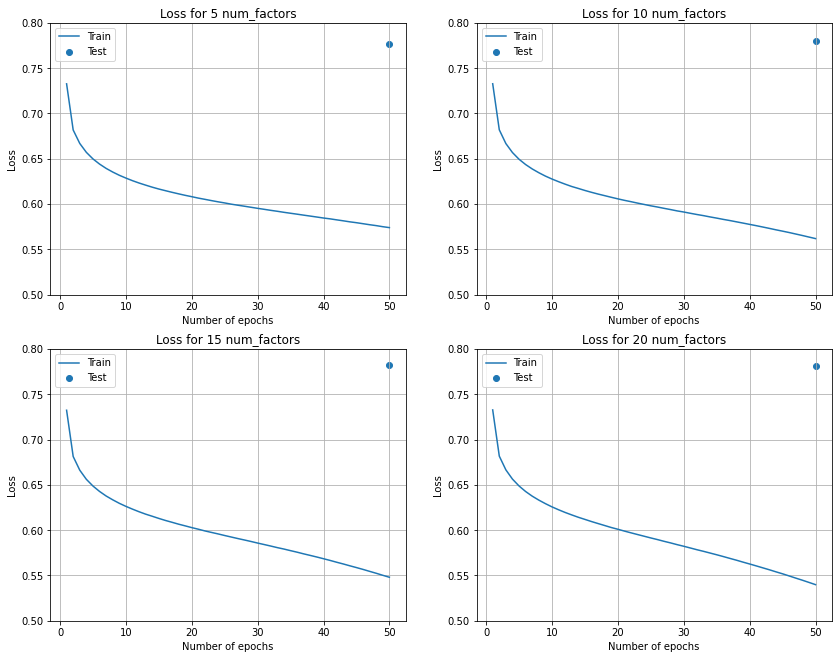

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
histories = [history_fm_5, history_fm_10, history_fm_15, history_fm_20]

fms = [fm_5, fm_10, fm_15, fm_20]
for i in range(0, 4):
    ax = axs[(i // 2, i % 2)]
    print(histories[i])
    ax.plot(np.arange(1, 51), histories[i], label='Train')
    ax.set_title(f'Loss for {(i+1) * 5} num_factors')
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('Loss')
    ax.set_ylim([0.5, 0.8])
    ax.scatter(50, mean_squared_error(test_y, fms[i].predict(X_test)), label='Test')
    ax.legend()
    ax.grid()

plt.show()

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Recommender Systems.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Recommender Systems.ipynb to pdf
[NbConvertApp] Support files will be in Recommender Systems_files/
[NbConvertApp] Making directory ./Recommender Systems_files
[NbConvertApp] Making directory ./Recommender Systems_files
[NbConvertApp] Making directory ./Recommender Systems_files
[NbConvertApp] Writing 73474 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 148315 bytes to /content/drive/My Drive/Recommender Systems.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'